In [79]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
plt.rcParams['figure.figsize'] = [15, 7]

In [90]:
df = pd.read_csv('Iris_with_outliers.csv')
df = df.dropna()
X = df.iloc[:, 2:4].values
y = df.iloc[:, 6].values
y = pd.get_dummies(df["Species"],dtype=int)
y = np.array(y)

In [91]:
def main(X,y):
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X, y)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, dist = main(X,y)

In [92]:
def generateArr(oriDist):
    arr = []
    for x in range(len(oriDist)):  # finds the distance away from that point (index 0)
        total = 0
        for y in range(len(oriDist[x])):
            # arr += [dist[x][0]+(dist[x][1]+dist[x][2])/2]
            total += oriDist[x][y]

        arr += [total]

    return arr

arr = generateArr(dist)

In [93]:
def boxplot(distO,X,):
        outliers = []
        percent = np.quantile(distO, [.25, .50, .75])

        upperL = percent[2] + 1.5 * (percent[2] - percent[0])
        lowerL = percent[0] - 1.5 * (percent[2] - percent[0])

        for x in range(len(distO)):
            if distO[x] > upperL:
                outliers += [X[x]]
            elif distO[x] < lowerL:
                outliers += [X[x]]
        
        return outliers

outliers = boxplot(arr,X)

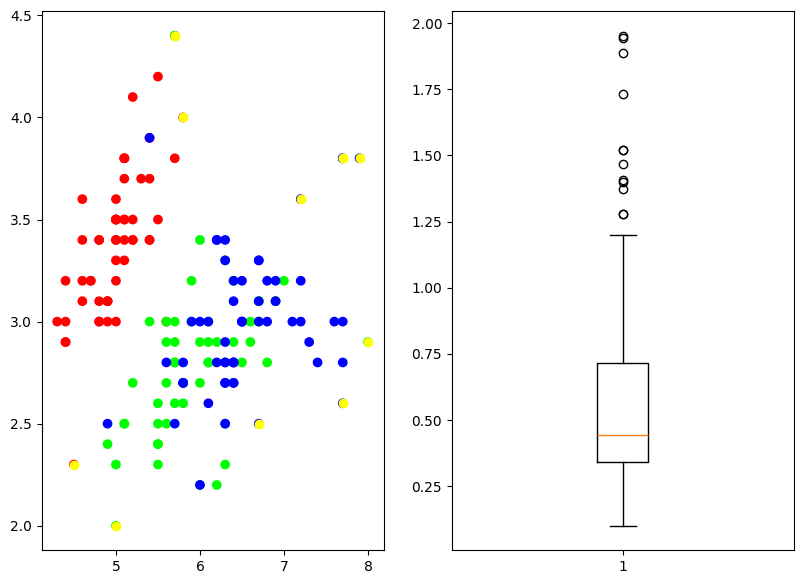

In [95]:
def printer(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1],c=y)
    plt.scatter(outliers[:, 0], outliers[:, 1], c="yellow")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printer(arr,X,y,outliers)